In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import data
import utils
from main import extract_summary, report_rouge_scores

%load_ext autoreload
%autoreload 2

### Cornell Newsroom Summarization Dataset

Data are donwloaded from the [cornell newsroom summarization dataset](https://summari.es/). We are using the development set. We select *extractive* for our task and only include data that has 5 or more sentences in the summary.

In [21]:
# Convert newsroom jason file (dev.jsonl) to csv file (uncomment and run the code if 'news_dev.csv' is not available)
#data.newsroom_json2csv()

In [2]:
# news = pd.read_csv('../data/newsroom/news_dev.csv')
# print('# of articles:', len(news))
# news.head()

# of articles: 2566


,title,reference,text
0,NEW YORKERS' ONLY REGRET WAS STAYING HOME,As many black men marched on Washington yester...,"This story was reported by: NICK CHARLES, AUST..."
1,Music review: Jake Bugg at the House of Blues,As the lights went down at the nearly sold-out...,As the lights went down at the nearly sold-out...
2,"HELP IS URGED FOR 36,000 HOMELESS IN CITY'S ST...",A yearlong study by the Community Service Soci...,A yearlong study by the Community Service Soci...
3,Broadway - An early contender for 1982-83 - 'I...,THE new Broadway season is barely out of the s...,THE new Broadway season is barely out of the s...
4,CIRCUS FINDS ARENA GOOD PLACE TO PLAY,EAST RUTHERFORD YOUNGSTERS squealed with laugh...,EAST RUTHERFORD YOUNGSTERS squealed with laugh...


### Summarization

- Summarization algorithms includes: 
    - SMRS (TF-IDF matrix)
    - Franke-Wolfe (TF-IDF matrix)
    - Franke-Wolfe (Sentence embeddings matrix)
- *Matlab* and *Python for matlab engine* is required to run the SMRS method. Remove `'SMRS'` from the `methods` list below if matlab is not installed.

- Main function: `extract_summary()`

```python
# Arguments:
#     - doc: string; article body text
#     - ref: string; reference summary
#     - title: string; title of the article
#     - k: number of extracted examplars
#     - print_summary: print summary text for each algorithm
#     - report_rouge: report rouge score (need to pass in ref argument)
#     - rouge_embed: use word embedding to calculate rouge score
#     - vectorize_scores: return scores in np.ndarray instead of in a dictionary
#     - methods: summarization algorithms to be used
# Return:
#     - summary: dictionary; extracted summary sentences using each algorithm
#     - word_count: dictionary; number of words in the extracted summary
#     - runtime: computation time of each algorithm
#     - scores: rouge score of each algorithm
        
summary, word_count, runtime, scores = extract_summary(doc, ref=None, title=None, k=5, print_summary=False, 
                                                       report_rouge=False, print_rouge=True, rouge_embed=False, 
                                                       vectorize_scores=False, methods=['random', 'SMRS', 'tfidf', 'embed']);

```

In [2]:
# Get list of titles, reference summaries, and body text
news_titles, news_refs, news_text = data.get_newsroom_data()

In [25]:
import time
from gensim.summarization.summarizer import summarize

In [6]:
doc_idx = 1
doc = news_text[doc_idx]
ref = news_refs[doc_idx]
title = news_titles[doc_idx]

In [26]:
%%time
runtime, scores = [], []
for doc, ref in zip(news_text[:20], news_refs[:20]):
    start = time.time()
    summary = summarize(doc)
    runtime.append(time.time() - start)
    scores.append(utils.get_rouge_score(summary, ref, verbose=False, vectorize=True))

CPU times: user 449 ms, sys: 0 ns, total: 449 ms
Wall time: 449 ms


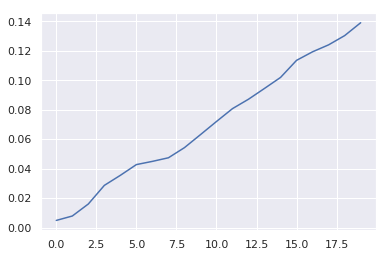

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
plt.plot(np.cumsum(runtime));

In [32]:
np.mean(scores, axis=0)

array([0.33471616, 0.30426431, 0.41941215, 0.21781206, 0.19938613,
       0.28478217, 0.28986835, 0.29644902, 0.4048617 ])

In [22]:
summary = summarize(doc)
print(summary)

as the lights went down at the nearly sold-out house of blues on saturday, robert johnson's 1936 delta blues “cross roads” came up, and 19-year-old jake bugg ambled onto the darkened stage with his two bandmates, greeted by shrieks from all sides.
with his fetching mop top and boyish charm, this jb comes off like the anti-pop justin beiber, reviving rock ’n’ roll as sincere but sexy folk music for the long-tailed digital age.


In [23]:
utils.get_rouge_score(summary, ref);

Overlap 1-gram 			F1: 0.552
Overlap 1-gram 			Precision: 0.815
Overlap 1-gram 			Recall: 0.417
Overlap bi-gram 		F1: 0.430
Overlap bi-gram 		Precision: 0.681
Overlap bi-gram 		Recall: 0.314
Longest Common Subsequence 	F1: 0.464
Longest Common Subsequence 	Precision: 0.815
Longest Common Subsequence 	Recall: 0.417


### Skip Thoughts

In [3]:
import skipthoughts
model = skipthoughts.load_model()
encoder = skipthoughts.Encoder(model)

Loading model parameters...
Compiling encoders...
Loading tables...
Packing up...


In [12]:
X = doc.split('. ')

In [13]:
X

["as the lights went down at the nearly sold-out house of blues on saturday, robert johnson's 1936 delta blues “cross roads” came up, and 19-year-old jake bugg ambled onto the darkened stage with his two bandmates, greeted by shrieks from all sides",
 ' with his fetching mop top and boyish charm, this jb comes off like the anti-pop justin beiber, reviving rock ’n’ roll as sincere but sexy folk music for the long-tailed digital age',
 " “definitely not the radio,” said 17-year-old stoneham resident caroline thompson when asked how she'd learned about the english singer-songwriter, whose 2012 debut topped the uk charts but never broke the us top 40",
 'instead, thompson and two separately interviewed older male concertgoers credited music festivals',
 'to promote his second album, “shangri la,” bugg has performed in boston several times recently, at successively larger venues',
 ' at the 2,400-capacity house of blues, the bassist and drummer planted themselves at either end of the large 

In [15]:
vectors = encoder.encode(X) 

48
36
38
13
24
31
42
74
7
41
33


In [16]:
vectors.shape

(11, 4800)

## Rest of the stuff

In [3]:
doc_idx = 0
doc = news_text[doc_idx]
ref = news_refs[doc_idx]
title = news_titles[doc_idx]

k=5
methods = ['SMRS', 'TextRank', 'tfidf', 'embed']
extract_summary(doc, ref, title, ratio=0.2, report_rouge=False, methods=methods, print_summary=True);

# sentence: 26, # vocab: 231
# of selected exemplar: 5

Title: NEW YORKERS' ONLY REGRET WAS STAYING HOME

=============== Referecne Text ==============
As many black men marched on Washington yesterday, some New Yorkers spoke of their pride in the event and their disappointment in not being there, too. "I felt like the only black person working,"said Roderick Vinson, 38, of Harlem. "That feeling made me sick to my stomach. I couldn't believe I missed one of the important events of my life."Winston Ford, 50, had to work, too. He makes his living selling
-----
Word count:71

========== Extracted summary: SMRS ==========
If we worked together, we'd be a great nation." "whites and blacks need each other. Winston ford, 50, had to work, too. "farrakhan's wrong," said allen washington, 61, a retired triborough bridge and tunnel authority worker. Charles williams, 45, an east elmhurst, queens, graphics worker, decided that the event was hollow.
-----
Word count:51
SMRS computation time: 0.371


### ROUGE Score

In [5]:
%%time
_ = extract_summary(doc, ref, title, k=k, report_rouge=True, rouge_embed=False, 
                    methods=methods, print_summary=False, print_rouge=True);


=============== ROUGE Scores ===============

SMRS
Overlap 1-gram 			F1: 0.145
Overlap 1-gram 			Precision: 0.160
Overlap 1-gram 			Recall: 0.133
Overlap bi-gram 		F1: 0.082
Overlap bi-gram 		Precision: 0.098
Overlap bi-gram 		Recall: 0.070
Longest Common Subsequence 	F1: 0.143
Longest Common Subsequence 	Precision: 0.160
Longest Common Subsequence 	Recall: 0.133

TextRank
Overlap 1-gram 			F1: 0.250
Overlap 1-gram 			Precision: 0.190
Overlap 1-gram 			Recall: 0.367
Overlap bi-gram 		F1: 0.181
Overlap bi-gram 		Precision: 0.133
Overlap bi-gram 		Recall: 0.282
Longest Common Subsequence 	F1: 0.211
Longest Common Subsequence 	Precision: 0.190
Longest Common Subsequence 	Recall: 0.367

tfidf
Overlap 1-gram 			F1: 0.173
Overlap 1-gram 			Precision: 0.164
Overlap 1-gram 			Recall: 0.183
Overlap bi-gram 		F1: 0.027
Overlap bi-gram 		Precision: 0.025
Overlap bi-gram 		Recall: 0.028
Longest Common Subsequence 	F1: 0.172
Longest Common Subsequence 	Precision: 0.164
Longest Common Subsequence 	

### Word Embedding ROUGE Score

In [9]:
%%time
_ = extract_summary(doc, ref, title, k=k, report_rouge=True, rouge_embed=True, 
                    methods=methods, print_summary=False, print_rouge=True);


=============== ROUGE Scores ===============

SMRS
Overlap 1-gram 			F1: 0.497
Overlap 1-gram 			Precision: 0.483
Overlap 1-gram 			Recall: 0.513
Overlap bi-gram 		F1: 0.652
Overlap bi-gram 		Precision: 0.668
Overlap bi-gram 		Recall: 0.636
Longest Common Subsequence 	F1: 0.550
Longest Common Subsequence 	Precision: 0.615
Longest Common Subsequence 	Recall: 0.513

TextRank
Overlap 1-gram 			F1: 0.461
Overlap 1-gram 			Precision: 0.406
Overlap 1-gram 			Recall: 0.533
Overlap bi-gram 		F1: 0.597
Overlap bi-gram 		Precision: 0.531
Overlap bi-gram 		Recall: 0.682
Longest Common Subsequence 	F1: 0.307
Longest Common Subsequence 	Precision: 0.275
Longest Common Subsequence 	Recall: 0.533

tfidf
Overlap 1-gram 			F1: 0.459
Overlap 1-gram 			Precision: 0.431
Overlap 1-gram 			Recall: 0.492
Overlap bi-gram 		F1: 0.570
Overlap bi-gram 		Precision: 0.542
Overlap bi-gram 		Recall: 0.601
Longest Common Subsequence 	F1: 0.422
Longest Common Subsequence 	Precision: 0.388
Longest Common Subsequence 	

### ROUGE Score Across Documents

In [3]:
k = 5
start = 0
num_articles = 20
articles = news_text[start : start + num_articles]
references = news_refs[start : start + num_articles]
titles = news_titles[start : start + num_articles]

In [4]:
%%time
methods = ['SMRS', 'tfidf', 'embed']
rouge_mean, rouge_median, rouge_std = report_rouge_scores(articles, references, titles, k, methods=methods)

index =  ['1-gram F1', '1-gram Precision', '1-gram Recall', 'bi-gram F1', 'bi-gram Precision', 'bi-gram Recall', 
          'longest common F1', 'longest common Precision', 'longest common Recall', 'runtime', 'word count']

print('=' * 22 + ' Mean ' + '=' * 22)
rouge_mean.index = index
display(rouge_mean)

# print('=' * 21 + ' Median ' + '=' * 21)
# rouge_median.index = index
# display(rouge_median)

# print('=' * 15 + ' Standard Deviation ' + '=' * 15)
# rouge_std.index = index
# display(rouge_std)

====================== Mean ======================


,SMRS,tfidf,embed
1-gram F1,0.179896,0.311096,0.237747
1-gram Precision,0.271224,0.305669,0.363580
1-gram Recall,0.146557,0.333223,0.189730
bi-gram F1,0.081752,0.184831,0.125861
bi-gram Precision,0.134461,0.180071,0.194909
bi-gram Recall,0.065963,0.202139,0.100072
longest common F1,0.152987,0.285602,0.200215
longest common Precision,0.265233,0.292907,0.357865
longest common Recall,0.143060,0.320208,0.185959
runtime,0.442194,0.003809,0.000979


CPU times: user 2min 42s, sys: 10 s, total: 2min 52s
Wall time: 3min 53s


In [5]:
%%time
# remove stop words
methods = ['SMRS', 'tfidf', 'embed']
rouge_mean, rouge_median, rouge_std = report_rouge_scores(articles, references, titles, k, methods=methods)

index =  ['1-gram F1', '1-gram Precision', '1-gram Recall', 'bi-gram F1', 'bi-gram Precision', 'bi-gram Recall', 
          'longest common F1', 'longest common Precision', 'longest common Recall', 'runtime', 'word count']

print('=' * 22 + ' Mean ' + '=' * 22)
rouge_mean.index = index
display(rouge_mean)

# print('=' * 21 + ' Median ' + '=' * 21)
# rouge_median.index = index
# display(rouge_median)

# print('=' * 15 + ' Standard Deviation ' + '=' * 15)
# rouge_std.index = index
# display(rouge_std)

====================== Mean ======================


,SMRS,tfidf,embed
1-gram F1,0.287058,0.273905,0.237281
1-gram Precision,0.361992,0.292616,0.378531
1-gram Recall,0.251540,0.274448,0.184089
bi-gram F1,0.170755,0.142804,0.116702
bi-gram Precision,0.217212,0.152740,0.195183
bi-gram Recall,0.148060,0.143740,0.090470
longest common F1,0.259015,0.248691,0.193543
longest common Precision,0.355476,0.279486,0.367970
longest common Recall,0.246831,0.262465,0.178213
runtime,0.454183,0.003967,0.000970


CPU times: user 2min 30s, sys: 9.92 s, total: 2min 39s
Wall time: 3min 41s


### Word Embedding ROUGE Score Across Documents

In [32]:
%%time
rouge_mean_embed, rouge_median_embed, rouge_std_embed = report_rouge_scores(articles, references, titles, k, 
                                                                            rouge_embed=True, methods=methods)

print('=' * 22 + ' Mean ' + '=' * 22)
rouge_mean_embed.index = index
display(rouge_mean_embed)

# print('=' * 21 + ' Median ' + '=' * 21)
# rouge_median_embed.index = index
# display(rouge_median_embed)

# print('=' * 15 + ' Standard Deviation ' + '=' * 15)
# rouge_std_embed.index = index
# display(rouge_std_embed)

====================== Mean ======================


,SMRS,tfidf,embed
1-gram F1,0.675342,0.719069,0.704342
1-gram Precision,0.754768,0.727654,0.794987
1-gram Recall,0.615283,0.714310,0.636428
bi-gram F1,0.737543,0.780718,0.761497
bi-gram Precision,0.791181,0.787599,0.812032
bi-gram Recall,0.692878,0.775532,0.718319
longest common F1,0.667800,0.685582,0.686588
longest common Precision,1.676865,0.885565,1.918299
longest common Recall,0.615283,0.714310,0.636428
runtime,0.445395,0.004235,0.001116


CPU times: user 15min 50s, sys: 49.6 s, total: 16min 39s
Wall time: 17min 13s


### Runtime

In [ ]:
%%time
k=5
num_articles = 100
methods = ['embed']
word_count_list, runtime_list = [], []
count = 1
for doc, ref, title in zip(news_text[:num_articles], news_refs[:num_articles], news_titles[:num_articles]):
    if count % 10 == 0: print('Processed %d documents' %count)
    _, word_count, runtime = extract_summary(doc, ref, title, k=k, report_rouge=False, methods=methods, print_summary=False);
    word_count_list.append(word_count)
    runtime_list.append(runtime)

In [ ]:
k = 5
start = 0
num_articles = 100
articles = news_text[start : start + num_articles]
references = news_refs[start : start + num_articles]
titles = news_titles[start : start + num_articles]

methods = ['SMRS', 'tfidf', 'embed']
rouge_mean, rouge_median, rouge_std = report_rouge_scores(articles, references, titles, k, methods=methods)

index =  ['1-gram F1', '1-gram Precision', '1-gram Recall', 'bi-gram F1', 'bi-gram Precision', 'bi-gram Recall', 
          'longest common F1', 'longest common Precision', 'longest common Recall', 'runtime', 'word count']

print('=' * 22 + ' Mean ' + '=' * 22)
rouge_mean.index = index
display(rouge_mean)